In [1]:
import os
import sys
import json
import argparse

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
import seaborn as sns

from glob import glob
from nilearn.glm.second_level import SecondLevelModel
from nilearn.glm.second_level import make_second_level_design_matrix
from nilearn.image import threshold_img
from nilearn.glm import threshold_stats_img

/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/glm/__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm module is experimental. '


In [2]:
from nilearn.masking import apply_mask
from scipy import stats

In [3]:
from nilearn import plotting, datasets, surface

# for plotting slices
mni152_template = datasets.load_mni152_template(resolution=1)
# for plotting on surface
fsaverage = datasets.fetch_surf_fsaverage('fsaverage')

In [4]:
task_label = 'tonecat'
contrast_label = 'sound'
fwhm = 0.00
space_label = 'MNI152NLin2009cAsym'

# define data directories
bidsroot = os.path.join('/bgfs/bchandrasekaran/krs228/data/', 
                        'FLT/',
                        'data_denoised', #'data_bids'
                       )
nilearn_dir = os.path.join(bidsroot, 'derivatives', 'nilearn')
masks_dir = os.path.join('/bgfs/bchandrasekaran/krs228/data/', 
                         'FLT/', 'data_bids', 'derivatives', 'nilearn', 'masks')
# define first-level directory where group-level inputs will be pulled from
l1_dir = os.path.join(nilearn_dir, 'level-1_fwhm-%.02f'%fwhm)

# create output directory
group_out_dir = os.path.join(nilearn_dir, 'group_fwhm-%.02f'%fwhm)
if not os.path.exists(group_out_dir):
        os.makedirs(group_out_dir)

Based on [nilearn documentation](https://nilearn.github.io/stable/auto_examples/05_glm_second_level/plot_thresholding.html#statistical-testing-of-a-second-level-analysis)

### Build the group-level design matrix

#### Read the `participants.tsv` file from the BIDS root directory

In [5]:
participants_fpath = os.path.join(bidsroot, 'participants.tsv')
participants_df = pd.read_csv(participants_fpath, sep='\t')

# subjects to ignore (not fully processed, etc.)
ignore_subs = ['sub-FLT27', # always leave out FLT27 – did not participate
               'sub-FLT07', # bad QA 11/14/23
               #'sub-FLT02', 'sub-FLT04', 'sub-FLT18', 'sub-FLT19', # currently reprocessing
              ]
participants_df.drop(participants_df[participants_df.participant_id.isin(ignore_subs)].index, inplace=True)

# re-sort by participant ID
participants_df.sort_values(by=['participant_id'], ignore_index=True, inplace=True)

In [6]:
print(participants_df)

   participant_id  age sex         group  FFR_id
0       sub-FLT02   21   F  non-Mandarin  1002.0
1       sub-FLT03   25   F      Mandarin  2002.0
2       sub-FLT04   21   F  non-Mandarin  1003.0
3       sub-FLT05   26   M      Mandarin  3010.0
4       sub-FLT06   21   F  non-Mandarin  3001.0
5       sub-FLT08   23   F      Mandarin  2005.0
6       sub-FLT09   30   F  non-Mandarin  3002.0
7       sub-FLT10   23   F      Mandarin  2006.0
8       sub-FLT11   20   F  non-Mandarin  1005.0
9       sub-FLT12   20   F  non-Mandarin  3004.0
10      sub-FLT13   23   F  non-Mandarin  3005.0
11      sub-FLT14   23   M  non-Mandarin  3006.0
12      sub-FLT15   22   M      Mandarin  2010.0
13      sub-FLT17   29   F      Mandarin     NaN
14      sub-FLT18   24   M      Mandarin  2016.0
15      sub-FLT19   24   M      Mandarin  2018.0
16      sub-FLT20   26   F  non-Mandarin  3008.0
17      sub-FLT21   21   M      Mandarin  2011.0
18      sub-FLT22   41   F      Mandarin  2017.0
19      sub-FLT23   

In [7]:
# create group-specific lists of subject IDs
sub_list_mand = list(participants_df.participant_id[participants_df.group=='Mandarin'])
sub_list_nman = list(participants_df.participant_id[participants_df.group=='non-Mandarin'])

In [8]:
print(sub_list_mand)

['sub-FLT03', 'sub-FLT05', 'sub-FLT08', 'sub-FLT10', 'sub-FLT15', 'sub-FLT17', 'sub-FLT18', 'sub-FLT19', 'sub-FLT21', 'sub-FLT22', 'sub-FLT23', 'sub-FLT24', 'sub-FLT26']


In [9]:
print(sub_list_nman)

['sub-FLT02', 'sub-FLT04', 'sub-FLT06', 'sub-FLT09', 'sub-FLT11', 'sub-FLT12', 'sub-FLT13', 'sub-FLT14', 'sub-FLT20', 'sub-FLT25', 'sub-FLT28', 'sub-FLT30']


#### Create design matrixes

In [10]:
# get participant IDs and their group labels
subjects_label = list(participants_df.participant_id)
groups_label = list(participants_df.group)

# make new dataframe from the group labels
design_mat_groupdiff = pd.DataFrame({'Mand': groups_label,
                                     'NMan': groups_label,
                                    }
                                   )
# convert to 1s and 0s for each group as appropriate
design_mat_groupdiff['Mand'].loc[design_mat_groupdiff['Mand'] == 'Mandarin'] = 1
design_mat_groupdiff['Mand'].loc[design_mat_groupdiff['Mand'] == 'non-Mandarin'] = 0
design_mat_groupdiff['NMan'].loc[design_mat_groupdiff['NMan'] == 'Mandarin'] = 0
design_mat_groupdiff['NMan'].loc[design_mat_groupdiff['NMan'] == 'non-Mandarin'] = 1
design_mat_groupdiff = design_mat_groupdiff.astype('int')
print(design_mat_groupdiff)

    Mand  NMan
0      0     1
1      1     0
2      0     1
3      1     0
4      0     1
5      1     0
6      0     1
7      1     0
8      0     1
9      0     1
10     0     1
11     0     1
12     1     0
13     1     0
14     1     0
15     1     0
16     0     1
17     1     0
18     1     0
19     1     0
20     1     0
21     0     1
22     1     0
23     0     1
24     0     1


### Get files

In [11]:
# get the beta map for the contrast of interest for each subject
l1_fnames_groupdiff = [sorted(glob(l1_dir+f'/{sub_id}_space-{space_label}/run-all_LSS/*contrast-{contrast_label}_model-LSS_map-beta.nii.gz'))[0] for sub_id in subjects_label]

In [12]:
l1_fnames_mand = [sorted(glob(l1_dir+f'/{sub_id}_space-{space_label}/run-all_LSS/*contrast-{contrast_label}_model-LSS_map-beta.nii.gz'))[0] for sub_id in sub_list_mand]
l1_fnames_nman = [sorted(glob(l1_dir+f'/{sub_id}_space-{space_label}/run-all_LSS/*contrast-{contrast_label}_model-LSS_map-beta.nii.gz'))[0] for sub_id in sub_list_nman]

# Dorsal striatum

### Define regions

In [13]:
## define ROIs
network_name = 'tian_subcortical_S3' # 'tian_subcortical_S3' # auditory

if network_name == 'auditory':
    roi_list_ordered = [
                'L-IC', 'L-MGN', 'L-HG', 'L-PT',  'L-PP', 'L-STGp', 'L-STGa', 'L-ParsOp', 'L-ParsTri',
                'R-IC', 'R-MGN', 'R-HG', 'R-PT',  'R-PP', 'R-STGp', 'R-STGa', 'R-ParsOp', 'R-ParsTri', 
               ]
elif network_name == 'aud-striatal':
    roi_list_ordered = ['L-Caud', 'L-Put', 'L-IC', 'L-MGN',
                'L-HG', 'L-PP', 'L-PT', 'L-STGa', 'L-STGp', 
                'L-ParsOp', 'L-ParsTri',
                'R-Caud', 'R-Put','R-IC', 'R-MGN',
                'R-HG', 'R-PP', 'R-PT', 'R-STGa', 'R-STGp', 
                'R-ParsOp', 'R-ParsTri',
               ]
elif network_name == 'tian_subcortical_S3':
    roi_list_ordered = [
        'CAU-DA-lh', 'CAU-DA-rh', 
        'CAU-VA-lh', 'CAU-VA-rh', 
        'pCAU-lh', 'pCAU-rh', 
        'PUT-DA-lh', 'PUT-DA-rh', 
        'PUT-DP-lh', 'PUT-DP-rh', 
        'PUT-VA-lh', 'PUT-VA-rh', 
        'PUT-VP-lh', 'PUT-VP-rh',
        'NAc-core-lh',  'NAc-core-rh', 
        'NAc-shell-lh', 'NAc-shell-rh', 
         #'aGP-lh', 'pGP-lh', 
         #'aGP-rh', 'pGP-rh',         
               ]
    
region_list = roi_list_ordered

In [14]:
print(region_list)

['CAU-DA-lh', 'CAU-DA-rh', 'CAU-VA-lh', 'CAU-VA-rh', 'pCAU-lh', 'pCAU-rh', 'PUT-DA-lh', 'PUT-DA-rh', 'PUT-DP-lh', 'PUT-DP-rh', 'PUT-VA-lh', 'PUT-VA-rh', 'PUT-VP-lh', 'PUT-VP-rh', 'NAc-core-lh', 'NAc-core-rh', 'NAc-shell-lh', 'NAc-shell-rh']


### Mask stat maps

In [15]:
roi_mean_dict = {}
for rx, region in enumerate(region_list):
    print(region)
    roi_mean_list = []
    
    for fx, stat_fpath in enumerate(l1_fnames_groupdiff):
        sub_id = subjects_label[fx]
        mask_fpath = glob(masks_dir + f'/{sub_id}/space-MNI152NLin2009cAsym/masks-*/*{region}*.nii.gz')[0]
        
        masked_data = apply_mask(stat_fpath, mask_fpath)
        roi_mean_sub = masked_data.mean()
        
        roi_mean_list.append(roi_mean_sub)
        
    roi_mean_dict[region] = roi_mean_list

CAU-DA-lh
CAU-DA-rh
CAU-VA-lh
CAU-VA-rh
pCAU-lh
pCAU-rh
PUT-DA-lh
PUT-DA-rh
PUT-DP-lh
PUT-DP-rh
PUT-VA-lh
PUT-VA-rh
PUT-VP-lh
PUT-VP-rh
NAc-core-lh
NAc-core-rh
NAc-shell-lh
NAc-shell-rh


In [16]:
roi_df = pd.DataFrame.from_dict(roi_mean_dict)

roi_df['participant_id'] = participants_df.participant_id
roi_df['participant_group'] = participants_df.group

In [17]:
roi_df_long = roi_df.melt(id_vars=["participant_id", "participant_group"], 
                          var_name="region", value_name="beta")

In [18]:
roi_df_long

,participant_id,participant_group,region,beta
0,sub-FLT02,non-Mandarin,CAU-DA-lh,0.883211
1,sub-FLT03,Mandarin,CAU-DA-lh,0.448251
2,sub-FLT04,non-Mandarin,CAU-DA-lh,5.211277
3,sub-FLT05,Mandarin,CAU-DA-lh,3.802642
4,sub-FLT06,non-Mandarin,CAU-DA-lh,3.934543
...,...,...,...,...
445,sub-FLT24,Mandarin,NAc-shell-rh,5.231452
446,sub-FLT25,non-Mandarin,NAc-shell-rh,1.467038
447,sub-FLT26,Mandarin,NAc-shell-rh,1.707949
448,sub-FLT28,non-Mandarin,NAc-shell-rh,2.838835


### split hemisphere into its own column

In [19]:
if network_name == 'auditory':
    roi_df_long['hemisphere'] = roi_df_long.region.str[0]
    roi_df_long['region'] = roi_df_long.region.str[2:]
elif network_name == 'tian_subcortical_S3':
    roi_df_long['hemisphere'] = roi_df_long.region.str[-2:]
    roi_df_long['region'] = roi_df_long.region.str[:-3]

In [20]:
roi_df_long

,participant_id,participant_group,region,beta,hemisphere
0,sub-FLT02,non-Mandarin,CAU-DA,0.883211,lh
1,sub-FLT03,Mandarin,CAU-DA,0.448251,lh
2,sub-FLT04,non-Mandarin,CAU-DA,5.211277,lh
3,sub-FLT05,Mandarin,CAU-DA,3.802642,lh
4,sub-FLT06,non-Mandarin,CAU-DA,3.934543,lh
...,...,...,...,...,...
445,sub-FLT24,Mandarin,NAc-shell,5.231452,rh
446,sub-FLT25,non-Mandarin,NAc-shell,1.467038,rh
447,sub-FLT26,Mandarin,NAc-shell,1.707949,rh
448,sub-FLT28,non-Mandarin,NAc-shell,2.838835,rh


### ROI plots

In [21]:
'''
fig, ax = plt.subplots(2, 1, figsize=(8,6), dpi=300)
yrange = [-10, 20]
sns.boxplot(data=roi_df_long.where(roi_df_long.participant_group=='Mandarin'), 
              x='region', y='beta', 
              hue='hemisphere',
              palette=['#fdb863','#b2abd2'],
              linewidth=0.5,
              ax=ax[0]);
sns.stripplot(data=roi_df_long.where(roi_df_long.participant_group=='Mandarin'), 
              x='region', y='beta', 
              hue='hemisphere',
              palette=['#e66101','#5e3c99'],
              dodge=True,
              linewidth=0.5,
              ax=ax[0]);
xmin, xmax = ax[0].get_xlim()
ax[0].hlines(y=0, xmin=xmin, xmax=xmax, color='0.5', linestyle='--', linewidth=0.5)
ax[0].set_ylim(yrange)
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=30, ha='center')
sns.move_legend(ax[0], "upper left", bbox_to_anchor=(1, 1))
ax[0].set_title('Native Mandarin speakers');

sns.boxplot(data=roi_df_long.where(roi_df_long.participant_group=='non-Mandarin'), 
              x='region', y='beta', 
              hue='hemisphere',
              palette=['#fdb863','#b2abd2'],
              linewidth=0.5,
              ax=ax[1]);
sns.stripplot(data=roi_df_long.where(roi_df_long.participant_group=='non-Mandarin'), 
              x='region', y='beta', 
              hue='hemisphere',
              palette=['#e66101','#5e3c99'],
              dodge=True,
              linewidth=0.5,
              ax=ax[1]);
xmin, xmax = ax[1].get_xlim()
ax[1].hlines(y=0, xmin=xmin, xmax=xmax, color='0.5', linestyle='--', linewidth=0.5)
ax[1].set_ylim(yrange)
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=30, ha='center')
sns.move_legend(ax[1], "upper left", bbox_to_anchor=(1, 1))
ax[1].set_title('Non-Mandarin speakers');

fig.tight_layout()
'''

'\nfig, ax = plt.subplots(2, 1, figsize=(8,6), dpi=300)\nyrange = [-10, 20]\nsns.boxplot(data=roi_df_long.where(roi_df_long.participant_group==\'Mandarin\'), \n              x=\'region\', y=\'beta\', \n              hue=\'hemisphere\',\n              palette=[\'#fdb863\',\'#b2abd2\'],\n              linewidth=0.5,\n              ax=ax[0]);\nsns.stripplot(data=roi_df_long.where(roi_df_long.participant_group==\'Mandarin\'), \n              x=\'region\', y=\'beta\', \n              hue=\'hemisphere\',\n              palette=[\'#e66101\',\'#5e3c99\'],\n              dodge=True,\n              linewidth=0.5,\n              ax=ax[0]);\nxmin, xmax = ax[0].get_xlim()\nax[0].hlines(y=0, xmin=xmin, xmax=xmax, color=\'0.5\', linestyle=\'--\', linewidth=0.5)\nax[0].set_ylim(yrange)\nax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=30, ha=\'center\')\nsns.move_legend(ax[0], "upper left", bbox_to_anchor=(1, 1))\nax[0].set_title(\'Native Mandarin speakers\');\n\nsns.boxplot(data=roi_df_long.wh

#### Non-Mandarin speaking group

/scratch/slurm-3260374/ipykernel_122915/3459962792.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=roi_df_long.where(roi_df_long.participant_group=='non-Mandarin'),
/scratch/slurm-3260374/ipykernel_122915/3459962792.py:2: UserWarning: 
The palette list has fewer values (1) than needed (9) and will cycle, which may produce an uninterpretable plot.
  sns.boxplot(data=roi_df_long.where(roi_df_long.participant_group=='non-Mandarin'),
/scratch/slurm-3260374/ipykernel_122915/3459962792.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(data=roi_df_long.where(roi_df_long.participant_group=='non-Mandarin'),
/scratch/slurm-3260374/ipykernel_122915/3459962792.py:11: UserWarning: 
The pa

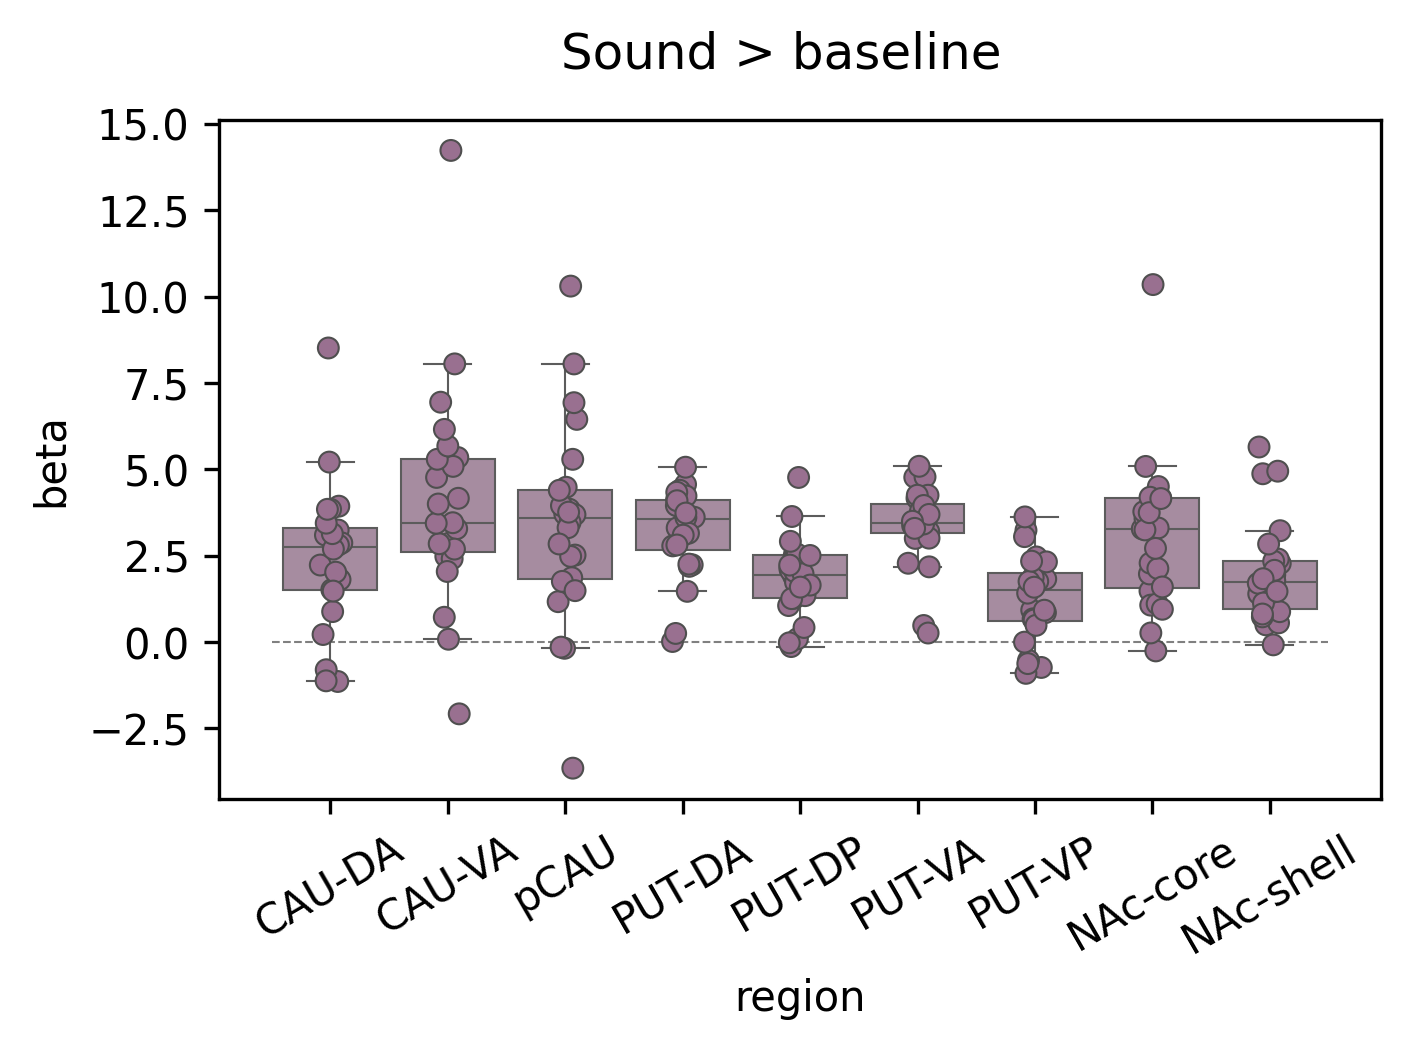

In [23]:
fig, ax = plt.subplots(figsize=(5,3), dpi=300)
sns.boxplot(data=roi_df_long.where(roi_df_long.participant_group=='non-Mandarin'), 
              x='region', y='beta', 
              #hue='hemisphere',
              #palette=['#fdb863','#b2abd2'],
              #dodge=True,
              palette=['#AA88A2'],
              fliersize=0,
              linewidth=0.5,
              ax=ax);
sns.stripplot(data=roi_df_long.where(roi_df_long.participant_group=='non-Mandarin'), 
              x='region', y='beta', 
              #hue='hemisphere',
              #palette=['#e66101','#5e3c99'],
              #dodge=True,
              palette=['#997090'],
              linewidth=0.5,
              ax=ax);
fig.suptitle('Sound > baseline')
xmin, xmax = ax.get_xlim()
ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='center')
ax.hlines(y=0, xmin=xmin, xmax=xmax, color='0.5', linestyle='--', linewidth=0.5)
#sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

/scratch/slurm-3260374/ipykernel_122915/4221528384.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='center')


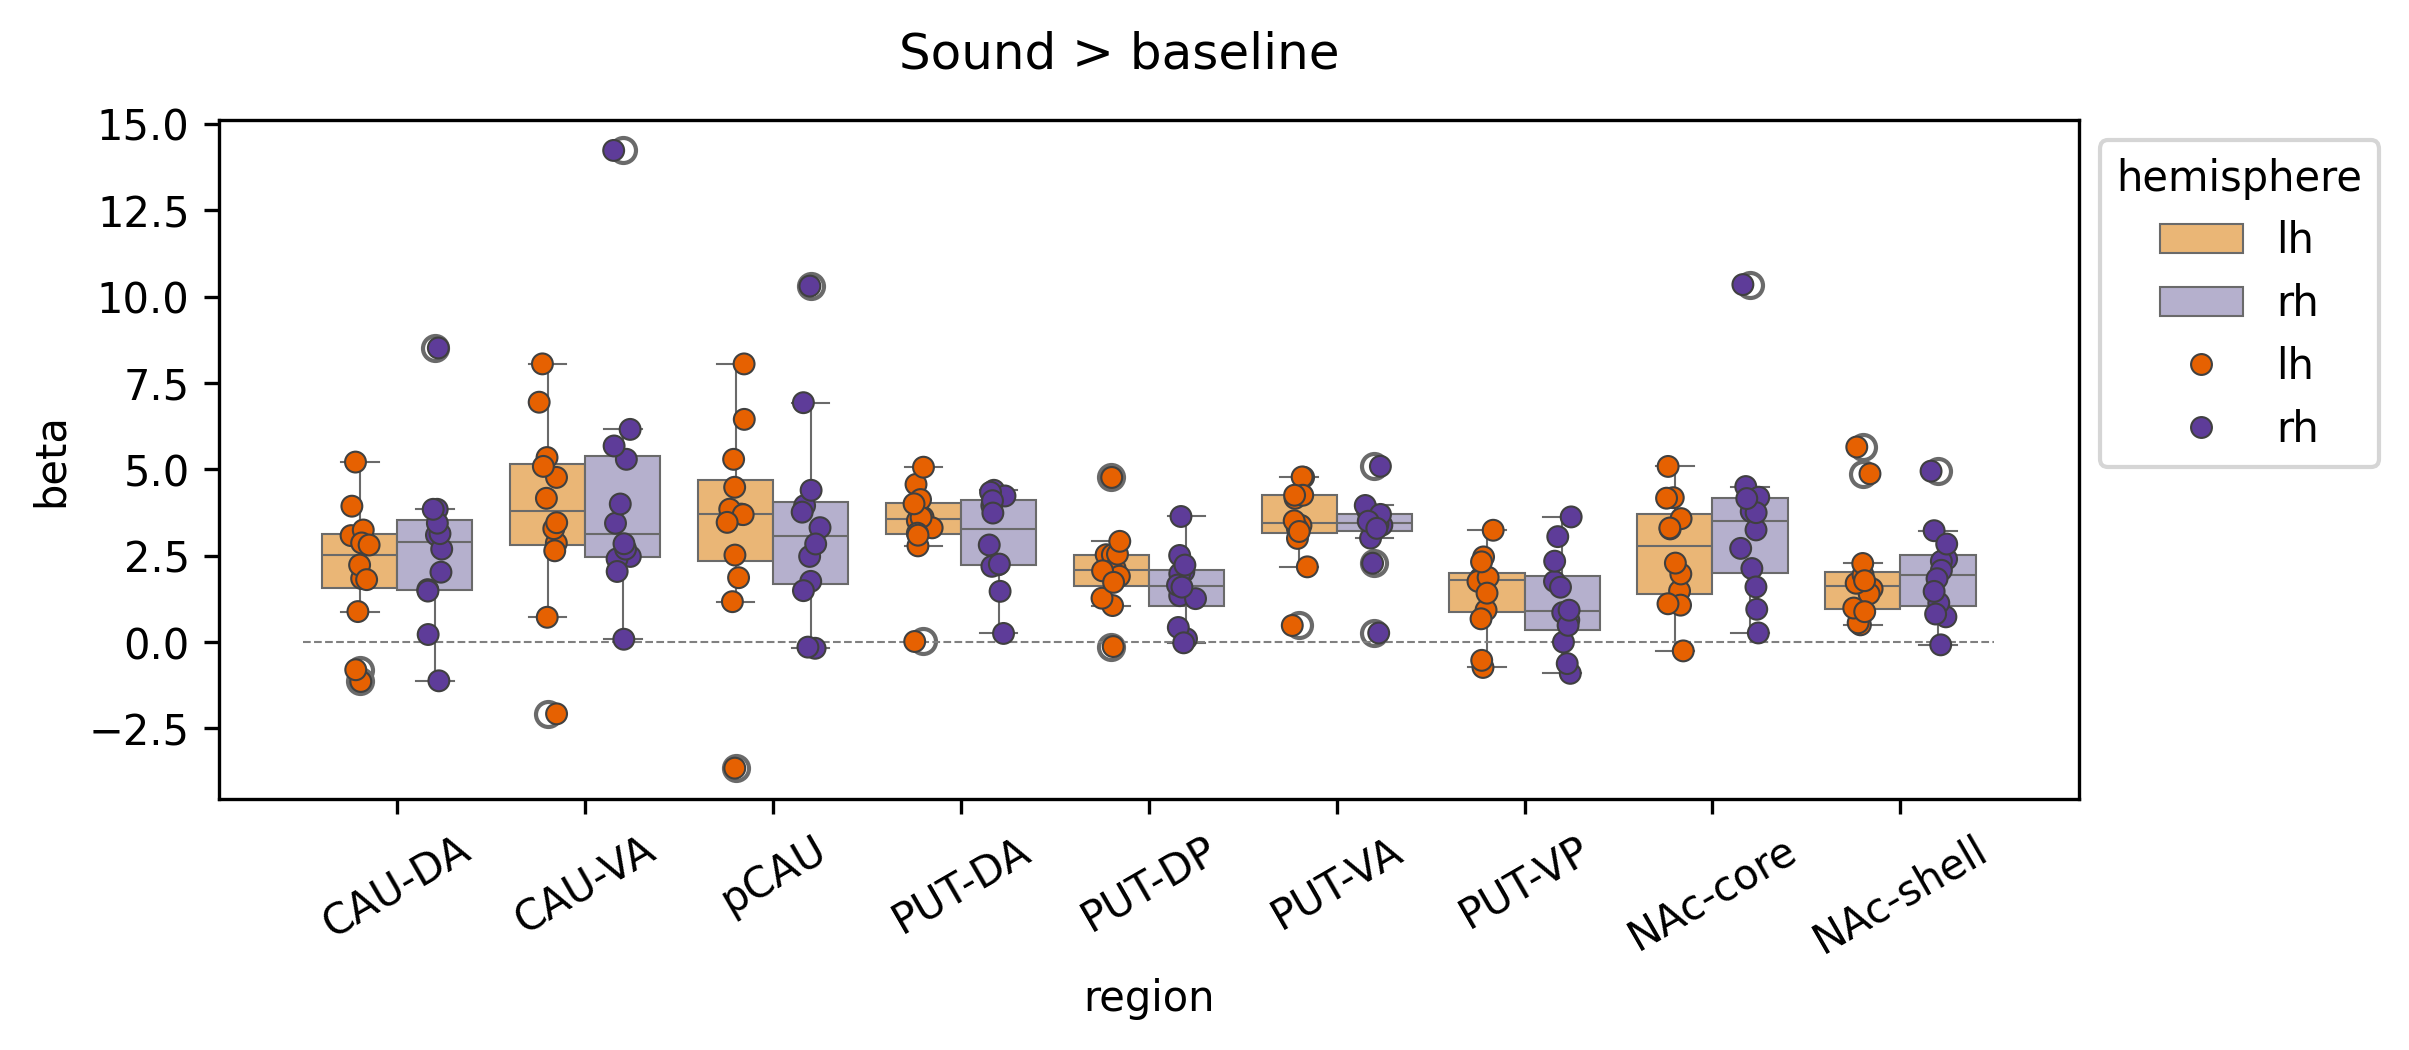

In [24]:
fig, ax = plt.subplots(figsize=(8,3), dpi=300)
sns.boxplot(data=roi_df_long.where(roi_df_long.participant_group=='non-Mandarin'), 
              x='region', y='beta', 
              hue='hemisphere',
              palette=['#fdb863','#b2abd2'],
              #dodge=True,
              linewidth=0.5,
              ax=ax);
sns.stripplot(data=roi_df_long.where(roi_df_long.participant_group=='non-Mandarin'), 
              x='region', y='beta', 
              hue='hemisphere',
              palette=['#e66101','#5e3c99'],
              dodge=True,
              linewidth=0.5,
              ax=ax);
fig.suptitle('Sound > baseline')
ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='center')
ax.hlines(y=0, xmin=xmin, xmax=xmax, color='0.5', linestyle='--', linewidth=0.5)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

### Statistics

#### Within-group, combining hemispheres

In [25]:
group = 'non-Mandarin'
#for group in np.unique(roi_df.participant_group):
p_vals = []
t_stats = []
print(f'\ngroup = {group}')
print('\nFDR-adjusted statistics')
for roi in np.unique(roi_df_long.region):
    groi_data = roi_df_long.where(roi_df_long.region==roi).dropna().beta
    res = stats.ttest_1samp(groi_data, popmean=0)
    #print(f't = {res.statistic:.02f} p = {res.pvalue:.04f} region = {roi}')
    p_vals.append(res.pvalue)
    t_stats.append(res.statistic)
p_vals_adj = stats.false_discovery_control(p_vals)
for rx, roi in enumerate(np.unique(roi_df_long.region)):
    if p_vals_adj[rx] < 0.05:
        ast = '**'
    elif p_vals[rx] < 0.05:
        ast = ' *'
    else:
        ast = '  '
    print(f'{ast}t = {t_stats[rx]:.02f} FDR-corr p = {p_vals_adj[rx]:.04f} uncorr p = {p_vals[rx]:.04f} region = {roi}')


group = non-Mandarin

FDR-adjusted statistics
**t = 7.24 FDR-corr p = 0.0000 uncorr p = 0.0000 region = CAU-DA
**t = 7.73 FDR-corr p = 0.0000 uncorr p = 0.0000 region = CAU-VA
**t = 7.23 FDR-corr p = 0.0000 uncorr p = 0.0000 region = NAc-core
**t = 5.85 FDR-corr p = 0.0000 uncorr p = 0.0000 region = NAc-shell
**t = 15.66 FDR-corr p = 0.0000 uncorr p = 0.0000 region = PUT-DA
**t = 12.42 FDR-corr p = 0.0000 uncorr p = 0.0000 region = PUT-DP
**t = 12.43 FDR-corr p = 0.0000 uncorr p = 0.0000 region = PUT-VA
**t = 8.26 FDR-corr p = 0.0000 uncorr p = 0.0000 region = PUT-VP
**t = 7.21 FDR-corr p = 0.0000 uncorr p = 0.0000 region = pCAU


#### Group differences

In [ ]:
p_vals = []
t_stats = []
print('\nGroup differences (Mandarin > non-Mandarin)')
for roi in region_list:
    mand_data = roi_df.where(roi_df.participant_group=='Mandarin').dropna()[roi]
    nman_data = roi_df.where(roi_df.participant_group=='non-Mandarin').dropna()[roi]
    res = stats.ttest_ind(mand_data, nman_data)
    #print(f'p = {res.pvalue:.04f} t = {res.statistic:.02f} region = {roi}')
    p_vals.append(res.pvalue)
    t_stats.append(res.statistic)
p_vals_adj = stats.false_discovery_control(p_vals)

print('\nFDR-adjusted statistics')
for rx, roi in enumerate(region_list):
    print(f't = {t_stats[rx]:.02f} p = {p_vals_adj[rx]:.04f} region = {roi}')

#### Within-group significance

In [29]:
for group in np.unique(roi_df.participant_group):
    p_vals = []
    t_stats = []
    print(f'\ngroup = {group}')
    print('\nFDR-adjusted statistics')
    for roi in region_list:
        groi_data = roi_df.where(roi_df.participant_group==group).dropna()[roi]
        res = stats.ttest_1samp(groi_data, popmean=0)
        #print(f't = {res.statistic:.02f} p = {res.pvalue:.04f} region = {roi}')
        p_vals.append(res.pvalue)
        t_stats.append(res.statistic)
    p_vals_adj = stats.false_discovery_control(p_vals)
    for rx, roi in enumerate(region_list):
        if p_vals_adj[rx] < 0.05:
            ast = '*'
        else:
            ast = ' '
        print(f'{ast}t = {t_stats[rx]:.02f} p = {p_vals_adj[rx]:.04f} region = {roi}')


group = Mandarin

FDR-adjusted statistics
*t = 3.12 p = 0.0123 region = CAU-DA-lh
*t = 3.21 p = 0.0112 region = CAU-DA-rh
*t = 2.97 p = 0.0151 region = CAU-VA-lh
*t = 4.18 p = 0.0029 region = CAU-VA-rh
*t = 2.80 p = 0.0192 region = pCAU-lh
*t = 3.69 p = 0.0062 region = pCAU-rh
*t = 7.28 p = 0.0001 region = PUT-DA-lh
*t = 6.76 p = 0.0001 region = PUT-DA-rh
*t = 6.82 p = 0.0001 region = PUT-DP-lh
*t = 6.53 p = 0.0001 region = PUT-DP-rh
*t = 3.58 p = 0.0068 region = PUT-VA-lh
*t = 6.63 p = 0.0001 region = PUT-VA-rh
*t = 5.01 p = 0.0009 region = PUT-VP-lh
*t = 4.49 p = 0.0019 region = PUT-VP-rh
 t = 2.20 p = 0.0539 region = NAc-core-lh
*t = 3.22 p = 0.0112 region = NAc-core-rh
 t = 1.83 p = 0.0979 region = NAc-shell-lh
 t = 1.59 p = 0.1371 region = NAc-shell-rh

group = non-Mandarin

FDR-adjusted statistics
*t = 4.09 p = 0.0022 region = CAU-DA-lh
*t = 3.99 p = 0.0022 region = CAU-DA-rh
*t = 4.85 p = 0.0010 region = CAU-VA-lh
*t = 4.15 p = 0.0022 region = CAU-VA-rh
*t = 4.04 p = 0.0022 reg

#### all participants

In [27]:
p_vals = []
t_stats = []
print(f'group = all')
for roi in region_list:
    groi_data = roi_df.dropna()[roi]
    res = stats.ttest_1samp(groi_data, popmean=0)
    #print(f't = {res.statistic:.02f} p = {res.pvalue:.04f} region = {roi}')
    p_vals.append(res.pvalue)
    t_stats.append(res.statistic)
    
# uncorrected stats
print('\nuncorrected statistics')
for rx, roi in enumerate(region_list):
    if p_vals[rx] < 0.01:
        ast = '**'
    elif p_vals[rx] < 0.05:
        ast = ' *'
    else:
        ast = '  '
    print(f'{ast}t = {t_stats[rx]:.02f} p = {p_vals[rx]:05f} region = {roi}')
    
# FDR-corrected stats
p_vals_adj = stats.false_discovery_control(p_vals)
print('\nFDR-adjusted statistics')
for rx, roi in enumerate(region_list):
    if p_vals_adj[rx] < 0.01:
        ast = '**'
    elif p_vals_adj[rx] < 0.05:
        ast = ' *'
    else:
        ast = '  '
    print(f'{ast}t = {t_stats[rx]:.02f} p = {p_vals_adj[rx]:.05f} region = {roi}')


group = all

uncorrected statistics
**t = 5.12 p = 0.000030 region = CAU-DA-lh
**t = 5.10 p = 0.000032 region = CAU-DA-rh
**t = 5.27 p = 0.000021 region = CAU-VA-lh
**t = 5.57 p = 0.000010 region = CAU-VA-rh
**t = 4.77 p = 0.000075 region = pCAU-lh
**t = 5.36 p = 0.000017 region = pCAU-rh
**t = 11.69 p = 0.000000 region = PUT-DA-lh
**t = 10.38 p = 0.000000 region = PUT-DA-rh
**t = 9.40 p = 0.000000 region = PUT-DP-lh
**t = 8.37 p = 0.000000 region = PUT-DP-rh
**t = 7.46 p = 0.000000 region = PUT-VA-lh
**t = 10.85 p = 0.000000 region = PUT-VA-rh
**t = 6.51 p = 0.000001 region = PUT-VP-lh
**t = 5.18 p = 0.000026 region = PUT-VP-rh
**t = 4.96 p = 0.000046 region = NAc-core-lh
**t = 5.31 p = 0.000019 region = NAc-core-rh
**t = 4.11 p = 0.000397 region = NAc-shell-lh
**t = 4.08 p = 0.000427 region = NAc-shell-rh

FDR-adjusted statistics
**t = 5.12 p = 0.00004 region = CAU-DA-lh
**t = 5.10 p = 0.00004 region = CAU-DA-rh
**t = 5.27 p = 0.00003 region = CAU-VA-lh
**t = 5.57 p = 0.00002 region 

### Plot on brain

CAU-DA-lh
CAU-DA-rh
CAU-VA-lh
CAU-VA-rh
pCAU-lh
pCAU-rh
PUT-DA-lh
PUT-DA-rh
PUT-DP-lh
PUT-DP-rh
PUT-VA-lh
PUT-VA-rh
PUT-VP-lh
PUT-VP-rh
NAc-core-lh
NAc-core-rh
NAc-shell-lh
NAc-shell-rh


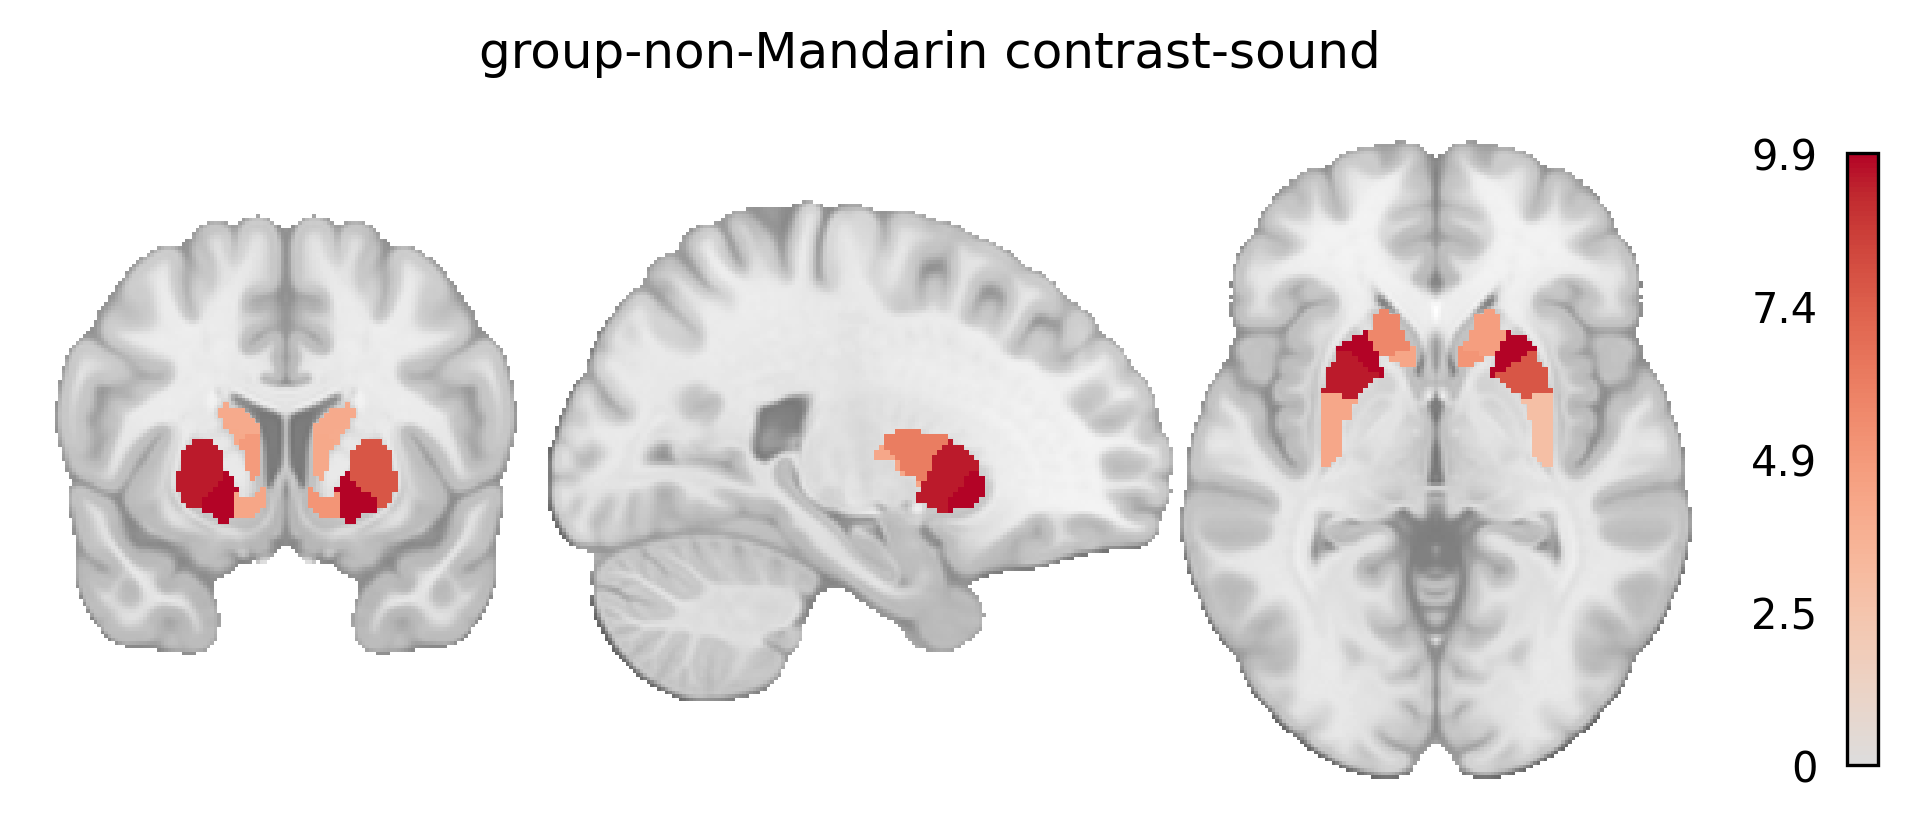

In [30]:
from nilearn.image import new_img_like
from nilearn import plotting

mask_path_list = []
for rx, region in enumerate(region_list):
    print(region)
    
    sub_id = subjects_label[fx]
    mask_fpath = glob(masks_dir + f'/{sub_id}/space-MNI152NLin2009cAsym/masks-*/*{region}*.nii.gz')[0]

    # create list of mask file paths
    mask_path_list.append(mask_fpath)

roi_stat_data_list = []
for rx, rpath in enumerate(mask_path_list):
    roi_img = nib.load(rpath)
    roi_data = roi_img.get_fdata()
    
    roi_stat = t_stats[rx]
    roi_stat_data = roi_data * roi_stat
    
    roi_stat_data_list.append(roi_stat_data)

# add maps together and make nifti img
roi_stat_map_data = sum(roi_stat_data_list)
roi_stat_map_img = new_img_like(roi_img, roi_stat_map_data)

title = f'group-{group} contrast-{contrast_label}'
fig, ax = plt.subplots(figsize=(8,3), dpi=300)
plotting.plot_stat_map(roi_stat_map_img,
                       bg_img=mni152_template,
                       draw_cross=False,
                       annotate=False,
                       black_bg=False,
                       cmap='coolwarm',
                       axes=ax)
fig.suptitle(title);

### 3D interactive plots

In [ ]:
import numpy as np
import nibabel as nib
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from matplotlib import cm
from skimage import measure
from scipy.ndimage import gaussian_filter

# Load NIfTI files into a list
nifti_files = mask_path_list

# Define a colormap
colormap = cm.get_cmap('Reds')

# Define the list of values for color plotting
color_values = t_stats  # Adjust these values as needed

# Create a list to hold the data for each segmentation
segmentations = []

# Loop through each NIfTI file and extract segmentation data
for nifti_file in nifti_files:
    nifti_data = nib.load(nifti_file)
    segmentation = nifti_data.get_fdata()
    segmentations.append(segmentation)

# Combine all segmentations into a single binary mask
combined_segmentation = np.any(segmentations, axis=0)

# Upsample the voxel data to a higher resolution grid
upsampled_segmentation = np.repeat(np.repeat(np.repeat(combined_segmentation, 2, axis=0), 2, axis=1), 2, axis=2)

# Smooth the upsampled voxel data with a Gaussian filter
smoothed_segmentation = gaussian_filter(upsampled_segmentation, sigma=1)

# Extract the surface mesh of the smoothed segmented region with adjusted level
vertices, faces, _, _ = measure.marching_cubes(smoothed_segmentation, level=smoothed_segmentation.mean())

# Translate vertices closer to the origin
center = vertices.mean(axis=0)
vertices -= center

# Create a subplot for the 3D plot with a larger size
fig = make_subplots(rows=1, cols=1, specs=[[{'type': 'mesh3d'}]], print_grid=False)

# Loop through each segmentation and add its surface plot to the subplot
for i, segmentation in enumerate(segmentations):
    # Upsample the voxel data to a higher resolution grid
    upsampled_segmentation = np.repeat(np.repeat(np.repeat(segmentation, 2, axis=0), 2, axis=1), 2, axis=2)
    
    # Smooth the upsampled voxel data with a Gaussian filter
    smoothed_segmentation = gaussian_filter(upsampled_segmentation, sigma=1)
    
    # Extract the surface mesh of the smoothed segmented region with adjusted level
    vertices, faces, _, _ = measure.marching_cubes(smoothed_segmentation, level=smoothed_segmentation.mean())
    
    vertices -= center
    
    # Map the color value to the colormap
    colormap_value = (color_values[i] - min(color_values)) / (max(color_values) - min(color_values))
    color = colormap(colormap_value)
    
    # Add the surface plot to the subplot
    fig.add_trace(go.Mesh3d(
        x=vertices[:, 0],
        y=vertices[:, 1],
        z=vertices[:, 2],
        i=faces[:, 0],
        j=faces[:, 1],
        k=faces[:, 2],
        color=f'rgb({int(color[0]*255)}, {int(color[1]*255)}, {int(color[2]*255)})',
        opacity=1,
        name= region_list[i] # f'Segmentation {i+1}'
    ))

# Set starting camera angle
camera = dict(
    up=dict(x=0, y=0, z=1),
    center=dict(x=0, y=0, z=0),
    eye=dict(x=-1.25, y=1.25, z=1.25)
)

# Update layout for the 3D plot to set a larger size and transparent background
fig.update_layout(
    scene=dict(
        xaxis=dict(title='X', showbackground=False, linecolor='rgba(0,0,0,0)', showticklabels=False),
        yaxis=dict(title='Y', showbackground=False, linecolor='rgba(0,0,0,0)', showticklabels=False),
        zaxis=dict(title='Z', showbackground=False, linecolor='rgba(0,0,0,0)', showticklabels=False),
        bgcolor='rgba(0,0,0,0)',  # Set background color to transparent
        camera=camera  # Set starting camera angle
    ),
    title=f'All participants contrast-{contrast_label}',
    width=800,  # Set width of the plot
    height=600,  # Set height of the plot
)

# Show the interactive plot
fig.show()

# Save the interactive plot as an SVG file
#fig.write_image(f'out-figure_group-all_contrast-{contrast_label}_model-LSS_surface.svg')

#### (test) Add colorbar 

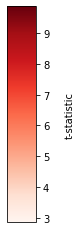

In [56]:
a = np.array([[min(color_values), max(color_values)]])
plt.figure(figsize=(0.5, 5))
img = pl.imshow(a, cmap=colormap)
plt.gca().set_visible(False)
cax = pl.axes([0.1, 0.2, 0.8, 0.6])
cbar = plt.colorbar(orientation="vertical", cax=cax, label='t-statistic')
cbar.ax.get_yaxis().labelpad = 15
#pl.savefig("colorbar.pdf")

## Run on cortex

### Define regions

In [46]:
network_name = 'auditory' # auditory

if network_name == 'auditory':
    roi_list_ordered = [
                #'L-IC', 'L-MGN', 
                'L-HG', 'L-PT',  'L-PP', 'L-STGp', 'L-STGa', 'L-ParsOp', 'L-ParsTri',
                #'R-IC', 'R-MGN', 
                'R-HG', 'R-PT',  'R-PP', 'R-STGp', 'R-STGa', 'R-ParsOp', 'R-ParsTri', 
               ]
elif network_name == 'aud-striatal':
    roi_list_ordered = ['L-Caud', 'L-Put', 'L-IC', 'L-MGN',
                'L-HG', 'L-PP', 'L-PT', 'L-STGa', 'L-STGp', 
                'L-ParsOp', 'L-ParsTri',
                'R-Caud', 'R-Put','R-IC', 'R-MGN',
                'R-HG', 'R-PP', 'R-PT', 'R-STGa', 'R-STGp', 
                'R-ParsOp', 'R-ParsTri',
               ]
elif network_name == 'tian_subcortical_S3':
    roi_list_ordered = [
        'CAU-DA-lh', 'CAU-DA-rh', 
        'CAU-VA-lh', 'CAU-VA-rh', 
        'pCAU-lh', 'pCAU-rh', 
        'PUT-DA-lh', 'PUT-DA-rh', 
        'PUT-DP-lh', 'PUT-DP-rh', 
        'PUT-VA-lh', 'PUT-VA-rh', 
        'PUT-VP-lh', 'PUT-VP-rh',
        'NAc-core-lh',  'NAc-core-rh', 
        'NAc-shell-lh', 'NAc-shell-rh', 
         #'aGP-lh', 'pGP-lh', 
         #'aGP-rh', 'pGP-rh',         
               ]
    
region_list = roi_list_ordered

In [47]:
print(region_list)

['L-HG', 'L-PT', 'L-PP', 'L-STGp', 'L-STGa', 'L-ParsOp', 'L-ParsTri', 'R-HG', 'R-PT', 'R-PP', 'R-STGp', 'R-STGa', 'R-ParsOp', 'R-ParsTri']


### Mask stat maps

In [48]:
roi_mean_dict = {}
for rx, region in enumerate(region_list):
    print(region)
    roi_mean_list = []
    
    for fx, stat_fpath in enumerate(l1_fnames_groupdiff):
        sub_id = subjects_label[fx]
        mask_fpath = glob(masks_dir + f'/{sub_id}/space-MNI152NLin2009cAsym/masks-*/*{region}*.nii.gz')[0]
        
        masked_data = apply_mask(stat_fpath, mask_fpath)
        roi_mean_sub = masked_data.mean()
        
        roi_mean_list.append(roi_mean_sub)
        
    roi_mean_dict[region] = roi_mean_list

L-HG
L-PT
L-PP
L-STGp
L-STGa
L-ParsOp
L-ParsTri
R-HG
R-PT
R-PP
R-STGp
R-STGa
R-ParsOp
R-ParsTri


In [49]:
roi_df = pd.DataFrame.from_dict(roi_mean_dict)

roi_df['participant_id'] = participants_df.participant_id
roi_df['participant_group'] = participants_df.group

In [50]:
roi_df_long = roi_df.melt(id_vars=["participant_id", "participant_group"], 
                          var_name="region", value_name="beta")

In [51]:
roi_df_long

,participant_id,participant_group,region,beta
0,sub-FLT02,non-Mandarin,L-HG,3.333938
1,sub-FLT03,Mandarin,L-HG,5.057708
2,sub-FLT04,non-Mandarin,L-HG,7.560856
3,sub-FLT05,Mandarin,L-HG,7.396357
4,sub-FLT06,non-Mandarin,L-HG,4.889379
...,...,...,...,...
345,sub-FLT24,Mandarin,R-ParsTri,-2.084556
346,sub-FLT25,non-Mandarin,R-ParsTri,-1.113266
347,sub-FLT26,Mandarin,R-ParsTri,1.143408
348,sub-FLT28,non-Mandarin,R-ParsTri,-2.977347


### split hemisphere into its own column

In [52]:
if network_name == 'auditory':
    roi_df_long['hemisphere'] = roi_df_long.region.str[0]
    roi_df_long['region'] = roi_df_long.region.str[2:]
elif network_name == 'tian_subcortical_S3':
    roi_df_long['hemisphere'] = roi_df_long.region.str[-2:]
    roi_df_long['region'] = roi_df_long.region.str[:-3]

In [53]:
roi_df_long

,participant_id,participant_group,region,beta,hemisphere
0,sub-FLT02,non-Mandarin,HG,3.333938,L
1,sub-FLT03,Mandarin,HG,5.057708,L
2,sub-FLT04,non-Mandarin,HG,7.560856,L
3,sub-FLT05,Mandarin,HG,7.396357,L
4,sub-FLT06,non-Mandarin,HG,4.889379,L
...,...,...,...,...,...
345,sub-FLT24,Mandarin,ParsTri,-2.084556,R
346,sub-FLT25,non-Mandarin,ParsTri,-1.113266,R
347,sub-FLT26,Mandarin,ParsTri,1.143408,R
348,sub-FLT28,non-Mandarin,ParsTri,-2.977347,R


### ROI plots

In [54]:
'''
fig, ax = plt.subplots(2, 1, figsize=(8,6), dpi=300)
yrange = [-10, 20]
sns.boxplot(data=roi_df_long.where(roi_df_long.participant_group=='Mandarin'), 
              x='region', y='beta', 
              hue='hemisphere',
              palette=['#fdb863','#b2abd2'],
              linewidth=0.5,
              ax=ax[0]);
sns.stripplot(data=roi_df_long.where(roi_df_long.participant_group=='Mandarin'), 
              x='region', y='beta', 
              hue='hemisphere',
              palette=['#e66101','#5e3c99'],
              dodge=True,
              linewidth=0.5,
              ax=ax[0]);
xmin, xmax = ax[0].get_xlim()
ax[0].hlines(y=0, xmin=xmin, xmax=xmax, color='0.5', linestyle='--', linewidth=0.5)
ax[0].set_ylim(yrange)
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=30, ha='center')
sns.move_legend(ax[0], "upper left", bbox_to_anchor=(1, 1))
ax[0].set_title('Native Mandarin speakers');

sns.boxplot(data=roi_df_long.where(roi_df_long.participant_group=='non-Mandarin'), 
              x='region', y='beta', 
              hue='hemisphere',
              palette=['#fdb863','#b2abd2'],
              linewidth=0.5,
              ax=ax[1]);
sns.stripplot(data=roi_df_long.where(roi_df_long.participant_group=='non-Mandarin'), 
              x='region', y='beta', 
              hue='hemisphere',
              palette=['#e66101','#5e3c99'],
              dodge=True,
              linewidth=0.5,
              ax=ax[1]);
xmin, xmax = ax[1].get_xlim()
ax[1].hlines(y=0, xmin=xmin, xmax=xmax, color='0.5', linestyle='--', linewidth=0.5)
ax[1].set_ylim(yrange)
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=30, ha='center')
sns.move_legend(ax[1], "upper left", bbox_to_anchor=(1, 1))
ax[1].set_title('Non-Mandarin speakers');

fig.tight_layout()
'''

'\nfig, ax = plt.subplots(2, 1, figsize=(8,6), dpi=300)\nyrange = [-10, 20]\nsns.boxplot(data=roi_df_long.where(roi_df_long.participant_group==\'Mandarin\'), \n              x=\'region\', y=\'beta\', \n              hue=\'hemisphere\',\n              palette=[\'#fdb863\',\'#b2abd2\'],\n              linewidth=0.5,\n              ax=ax[0]);\nsns.stripplot(data=roi_df_long.where(roi_df_long.participant_group==\'Mandarin\'), \n              x=\'region\', y=\'beta\', \n              hue=\'hemisphere\',\n              palette=[\'#e66101\',\'#5e3c99\'],\n              dodge=True,\n              linewidth=0.5,\n              ax=ax[0]);\nxmin, xmax = ax[0].get_xlim()\nax[0].hlines(y=0, xmin=xmin, xmax=xmax, color=\'0.5\', linestyle=\'--\', linewidth=0.5)\nax[0].set_ylim(yrange)\nax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=30, ha=\'center\')\nsns.move_legend(ax[0], "upper left", bbox_to_anchor=(1, 1))\nax[0].set_title(\'Native Mandarin speakers\');\n\nsns.boxplot(data=roi_df_long.wh

#### Non-Mandarin speaking group

/scratch/slurm-3204847/ipykernel_1838/3459962792.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=roi_df_long.where(roi_df_long.participant_group=='non-Mandarin'),
/scratch/slurm-3204847/ipykernel_1838/3459962792.py:2: UserWarning: 
The palette list has fewer values (1) than needed (7) and will cycle, which may produce an uninterpretable plot.
  sns.boxplot(data=roi_df_long.where(roi_df_long.participant_group=='non-Mandarin'),
/scratch/slurm-3204847/ipykernel_1838/3459962792.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(data=roi_df_long.where(roi_df_long.participant_group=='non-Mandarin'),
/scratch/slurm-3204847/ipykernel_1838/3459962792.py:11: UserWarning: 
The palette li

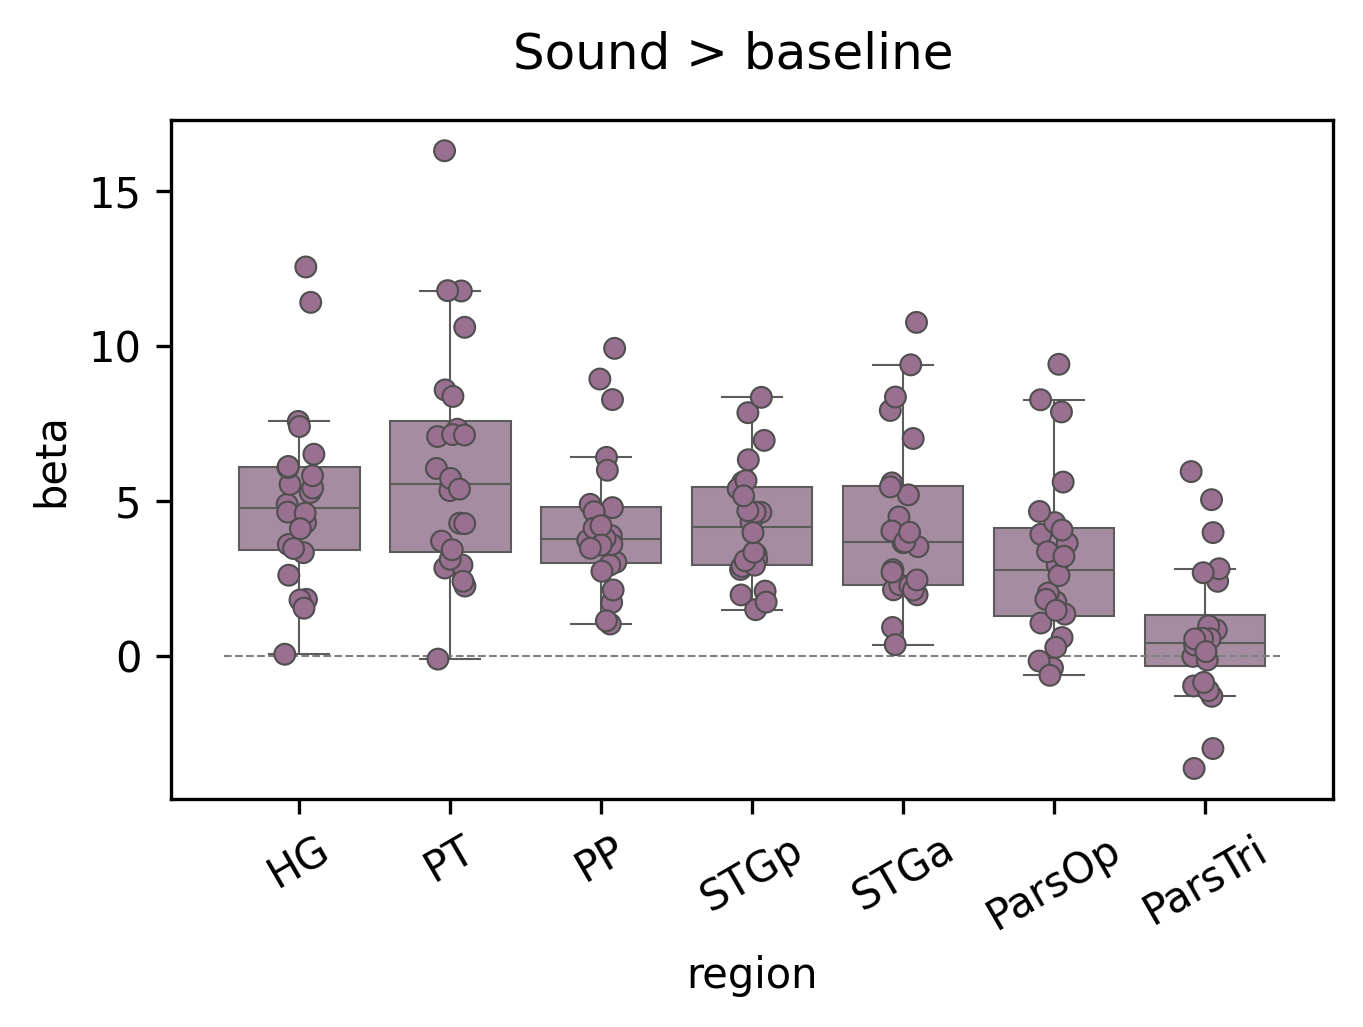

In [58]:
fig, ax = plt.subplots(figsize=(5,3), dpi=300)
sns.boxplot(data=roi_df_long.where(roi_df_long.participant_group=='non-Mandarin'), 
              x='region', y='beta', 
              #hue='hemisphere',
              #palette=['#fdb863','#b2abd2'],
              #dodge=True,
              palette=['#AA88A2'],
              fliersize=0,
              linewidth=0.5,
              ax=ax);
sns.stripplot(data=roi_df_long.where(roi_df_long.participant_group=='non-Mandarin'), 
              x='region', y='beta', 
              #hue='hemisphere',
              #palette=['#e66101','#5e3c99'],
              #dodge=True,
              palette=['#997090'],
              linewidth=0.5,
              ax=ax);
fig.suptitle('Sound > baseline')
xmin, xmax = ax.get_xlim()
ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='center')
ax.hlines(y=0, xmin=xmin, xmax=xmax, color='0.5', linestyle='--', linewidth=0.5)
#sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

#### all participants

In [56]:
'''
fig, ax = plt.subplots(figsize=(8,3), dpi=300)
sns.boxplot(data=roi_df_long, 
              x='region', y='beta', 
              hue='hemisphere',
              palette=['#fdb863','#b2abd2'],
              #dodge=True,
              linewidth=0.5,
              ax=ax);
sns.stripplot(data=roi_df_long, 
              x='region', y='beta', 
              hue='hemisphere',
              palette=['#e66101','#5e3c99'],
              dodge=True,
              linewidth=0.5,
              ax=ax);
fig.suptitle('All participants')
ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='center')
ax.hlines(y=0, xmin=xmin, xmax=xmax, color='0.5', linestyle='--', linewidth=0.5)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
'''

'\nfig, ax = plt.subplots(figsize=(8,3), dpi=300)\nsns.boxplot(data=roi_df_long, \n              x=\'region\', y=\'beta\', \n              hue=\'hemisphere\',\n              palette=[\'#fdb863\',\'#b2abd2\'],\n              #dodge=True,\n              linewidth=0.5,\n              ax=ax);\nsns.stripplot(data=roi_df_long, \n              x=\'region\', y=\'beta\', \n              hue=\'hemisphere\',\n              palette=[\'#e66101\',\'#5e3c99\'],\n              dodge=True,\n              linewidth=0.5,\n              ax=ax);\nfig.suptitle(\'All participants\')\nax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha=\'center\')\nax.hlines(y=0, xmin=xmin, xmax=xmax, color=\'0.5\', linestyle=\'--\', linewidth=0.5)\nsns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))\n'

### Statistics

#### Within-group, combining hemispheres

In [57]:
group = 'non-Mandarin'
#for group in np.unique(roi_df.participant_group):
p_vals = []
t_stats = []
print(f'\ngroup = {group}')
print('\nFDR-adjusted statistics')
for roi in np.unique(roi_df_long.region):
    groi_data = roi_df_long.where(roi_df_long.region==roi).dropna().beta
    res = stats.ttest_1samp(groi_data, popmean=0)
    #print(f't = {res.statistic:.02f} p = {res.pvalue:.04f} region = {roi}')
    p_vals.append(res.pvalue)
    t_stats.append(res.statistic)
p_vals_adj = stats.false_discovery_control(p_vals)
for rx, roi in enumerate(np.unique(roi_df_long.region)):
    if p_vals_adj[rx] < 0.05:
        ast = '**'
    elif p_vals[rx] < 0.05:
        ast = ' *'
    else:
        ast = '  '
    print(f'{ast}t = {t_stats[rx]:.02f} FDR-corr p = {p_vals_adj[rx]:.04f} uncorr p = {p_vals[rx]:.04f} region = {roi}')


group = non-Mandarin

FDR-adjusted statistics
**t = 16.12 FDR-corr p = 0.0000 uncorr p = 0.0000 region = HG
**t = 14.04 FDR-corr p = 0.0000 uncorr p = 0.0000 region = PP
**t = 13.87 FDR-corr p = 0.0000 uncorr p = 0.0000 region = PT
**t = 7.20 FDR-corr p = 0.0000 uncorr p = 0.0000 region = ParsOp
**t = 2.56 FDR-corr p = 0.0135 uncorr p = 0.0135 region = ParsTri
**t = 12.55 FDR-corr p = 0.0000 uncorr p = 0.0000 region = STGa
**t = 16.16 FDR-corr p = 0.0000 uncorr p = 0.0000 region = STGp


#### Within-group significance

In [37]:
for group in np.unique(roi_df.participant_group):
    p_vals = []
    t_stats = []
    print(f'\ngroup = {group}')
    print('\nFDR-adjusted statistics')
    for roi in region_list:
        groi_data = roi_df.where(roi_df.participant_group==group).dropna()[roi]
        res = stats.ttest_1samp(groi_data, popmean=0)
        #print(f't = {res.statistic:.02f} p = {res.pvalue:.04f} region = {roi}')
        p_vals.append(res.pvalue)
        t_stats.append(res.statistic)
    p_vals_adj = stats.false_discovery_control(p_vals)
    for rx, roi in enumerate(region_list):
        if p_vals_adj[rx] < 0.05:
            ast = '*'
        else:
            ast = ' '
        print(f'{ast}t = {t_stats[rx]:.02f} p = {p_vals_adj[rx]:.04f} region = {roi}')


group = Mandarin

FDR-adjusted statistics
*t = 12.65 p = 0.0000 region = L-HG
*t = 9.33 p = 0.0000 region = L-PT
*t = 9.13 p = 0.0000 region = L-PP
*t = 7.36 p = 0.0000 region = L-STGp
*t = 6.71 p = 0.0000 region = L-STGa
*t = 3.32 p = 0.0072 region = L-ParsOp
 t = 1.88 p = 0.0919 region = L-ParsTri
*t = 10.74 p = 0.0000 region = R-HG
*t = 9.65 p = 0.0000 region = R-PT
*t = 6.01 p = 0.0001 region = R-PP
*t = 10.31 p = 0.0000 region = R-STGp
*t = 8.08 p = 0.0000 region = R-STGa
*t = 3.92 p = 0.0026 region = R-ParsOp
 t = 1.12 p = 0.2865 region = R-ParsTri

group = non-Mandarin

FDR-adjusted statistics
*t = 6.82 p = 0.0001 region = L-HG
*t = 6.17 p = 0.0001 region = L-PT
*t = 6.58 p = 0.0001 region = L-PP
*t = 7.55 p = 0.0001 region = L-STGp
*t = 4.79 p = 0.0008 region = L-STGa
*t = 4.40 p = 0.0013 region = L-ParsOp
*t = 2.68 p = 0.0230 region = L-ParsTri
*t = 5.30 p = 0.0004 region = R-HG
*t = 5.23 p = 0.0004 region = R-PT
*t = 6.35 p = 0.0001 region = R-PP
*t = 8.13 p = 0.0001 region 

### Plot on brain

L-HG
L-PT
L-PP
L-STGp
L-STGa
L-ParsOp
L-ParsTri
R-HG
R-PT
R-PP
R-STGp
R-STGa
R-ParsOp
R-ParsTri


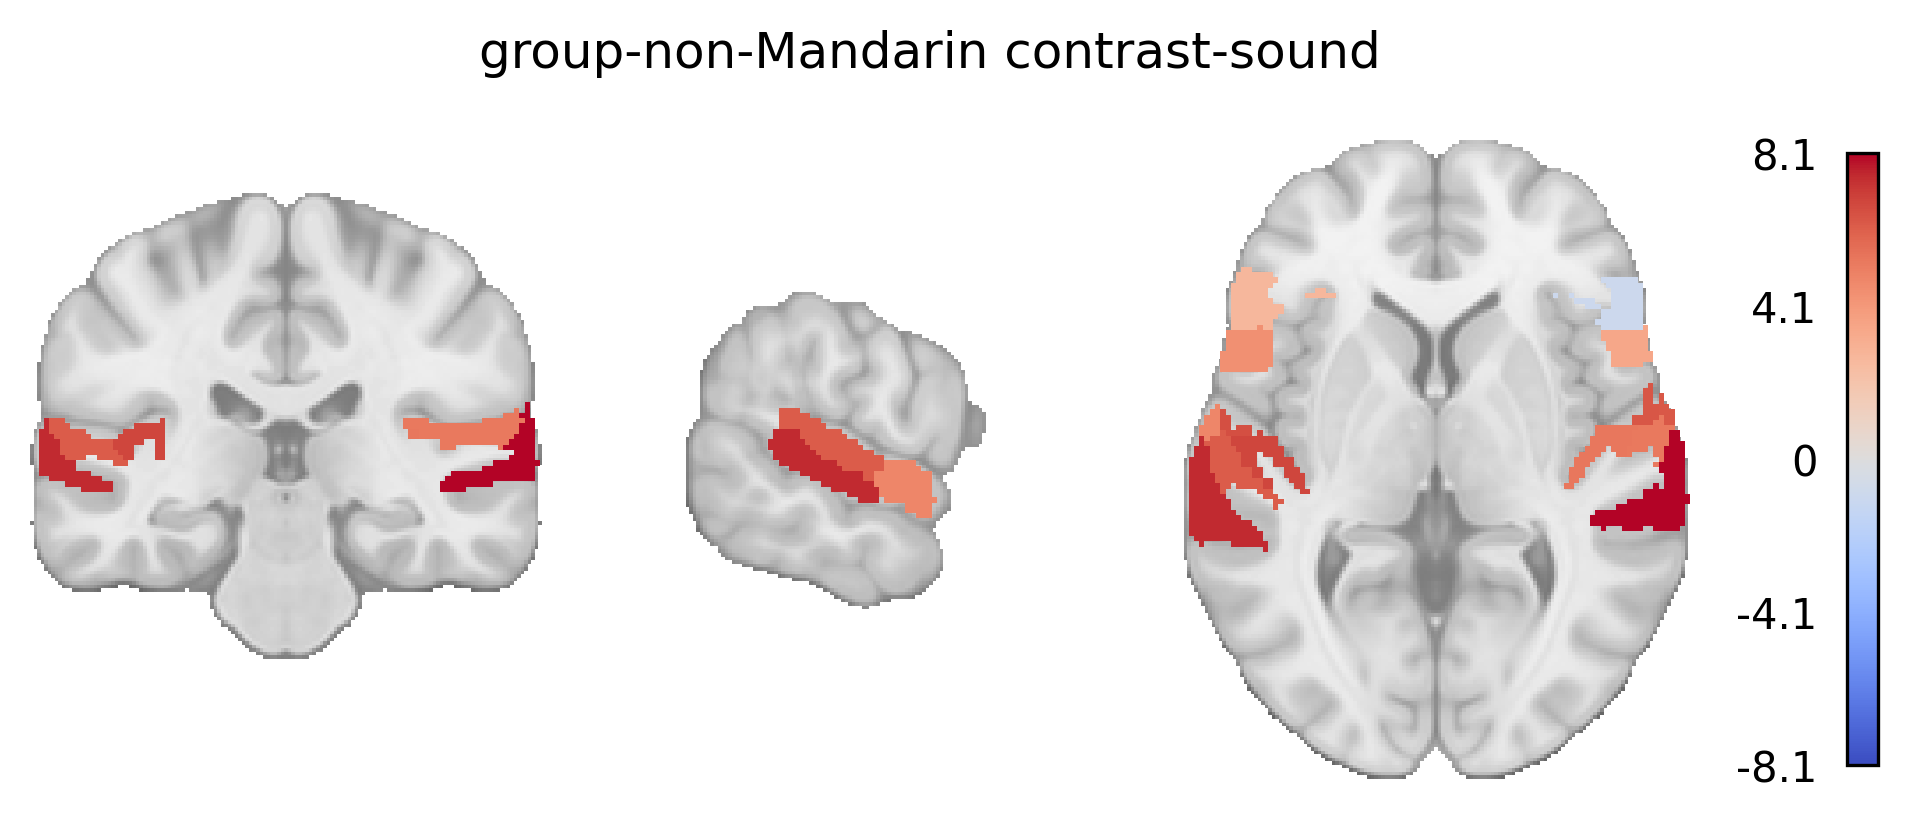

In [62]:
from nilearn.image import new_img_like
from nilearn import plotting

mask_path_list = []
for rx, region in enumerate(region_list):
    print(region)
    
    sub_id = subjects_label[fx]
    mask_fpath = glob(masks_dir + f'/{sub_id}/space-MNI152NLin2009cAsym/masks-*/*{region}*.nii.gz')[0]

    # create list of mask file paths
    mask_path_list.append(mask_fpath)

roi_stat_data_list = []
for rx, rpath in enumerate(mask_path_list):
    roi_img = nib.load(rpath)
    roi_data = roi_img.get_fdata()
    
    roi_stat = t_stats[rx]
    roi_stat_data = roi_data * roi_stat
    
    roi_stat_data_list.append(roi_stat_data)

# add maps together and make nifti img
roi_stat_map_data = sum(roi_stat_data_list)
roi_stat_map_img = new_img_like(roi_img, roi_stat_map_data)

title = f'group-{group} contrast-{contrast_label}'
fig, ax = plt.subplots(figsize=(8,3), dpi=300)
plotting.plot_stat_map(roi_stat_map_img,
                       bg_img=mni152_template,
                       draw_cross=False,
                       annotate=False,
                       black_bg=False,
                       cmap='coolwarm',
                       axes=ax)
fig.suptitle(title);

#### Surface plot

In [65]:
gm_mask_file = '/bgfs/bchandrasekaran/krs228/data/FLT/data_bids/derivatives/nilearn/masks/sub-FLT30/space-MNI152NLin2009cAsym/masks-dseg/sub-FLT30_space-MNI152NLin2009cAsym_mask-gm.nii.gz'
gm_mask_data = nib.load(gm_mask_file).get_fdata()

In [67]:
color_values

[6.823460739659008,
 6.167202419713443,
 6.581303895707519,
 7.549402206402698,
 4.791096444428236,
 4.402894110035934,
 2.6806464446035223,
 5.300300824889226,
 5.2289278273871185,
 6.354844000371274,
 8.133221826726805,
 6.294358057660195,
 3.4496749036678134,
 -1.004652469962035]

In [ ]:
import numpy as np
import nibabel as nib
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from matplotlib import cm
from skimage import measure
from scipy.ndimage import gaussian_filter

# Load NIfTI files into a list
nifti_files = mask_path_list

# Define a colormap
colormap = cm.get_cmap('Reds')

# Define the list of values for color plotting
color_values = t_stats  # Adjust these values as needed

# Create a list to hold the data for each segmentation
segmentations = []

# Loop through each NIfTI file and extract segmentation data
for nifti_file in nifti_files:
    nifti_data = nib.load(nifti_file)
    segmentation = nifti_data.get_fdata()
    segmentations.append(segmentation)


# Combine all segmentations into a single binary mask
combined_segmentation = np.any(segmentations, axis=0)

# Upsample the voxel data to a higher resolution grid
upsampled_segmentation = np.repeat(np.repeat(np.repeat(combined_segmentation, 2, axis=0), 2, axis=1), 2, axis=2)

# Smooth the upsampled voxel data with a Gaussian filter
smoothed_segmentation = gaussian_filter(upsampled_segmentation, sigma=1)

# Extract the surface mesh of the smoothed segmented region with adjusted level
vertices, faces, _, _ = measure.marching_cubes(smoothed_segmentation, level=smoothed_segmentation.mean())

# Translate vertices closer to the origin
center = vertices.mean(axis=0)
vertices -= center

# Create a subplot for the 3D plot with a larger size
fig = make_subplots(rows=1, cols=1, specs=[[{'type': 'mesh3d'}]], print_grid=False)

# Loop through each segmentation and add its surface plot to the subplot
for i, segmentation in enumerate(segmentations):
    # Upsample the voxel data to a higher resolution grid
    upsampled_segmentation = np.repeat(np.repeat(np.repeat(segmentation, 2, axis=0), 2, axis=1), 2, axis=2)
    
    # Smooth the upsampled voxel data with a Gaussian filter
    smoothed_segmentation = gaussian_filter(upsampled_segmentation, sigma=1)
    
    # Extract the surface mesh of the smoothed segmented region with adjusted level
    vertices, faces, _, _ = measure.marching_cubes(smoothed_segmentation, level=smoothed_segmentation.mean())
    
    vertices -= center
    
    # Map the color value to the colormap
    colormap_value = (color_values[i] - min(color_values)) / (max(color_values) - min(color_values))
    color = colormap(colormap_value)
    
    # Add the surface plot to the subplot
    fig.add_trace(go.Mesh3d(
        x=vertices[:, 0],
        y=vertices[:, 1],
        z=vertices[:, 2],
        i=faces[:, 0],
        j=faces[:, 1],
        k=faces[:, 2],
        color=f'rgb({int(color[0]*255)}, {int(color[1]*255)}, {int(color[2]*255)})',
        opacity=1,
        name= region_list[i] # f'Segmentation {i+1}'
    ))
    
    # DOES NOT APPEAR TO WORK
    '''
    # Add annotation for the region value
    region_value = color_values[i]
    fig.add_annotation(
        x=vertices[:, 0].mean(),
        y=vertices[:, 1].mean(),
        text=f'Region Value: {region_value:.2f}',
        showarrow=False,
        font=dict(color='white', size=12)
    )
    '''
# Set starting camera angle
camera = dict(
    up=dict(x=0, y=0, z=1),
    center=dict(x=0, y=0, z=0),
    eye=dict(x=-1.25, y=1.25, z=1.25)
)

# Update layout for the 3D plot to set a larger size and transparent background
fig.update_layout(
    scene=dict(
        xaxis=dict(title='X', showbackground=False, linecolor='rgba(0,0,0,0)', showticklabels=False),
        yaxis=dict(title='Y', showbackground=False, linecolor='rgba(0,0,0,0)', showticklabels=False),
        zaxis=dict(title='Z', showbackground=False, linecolor='rgba(0,0,0,0)', showticklabels=False),
        bgcolor='rgba(0,0,0,0)',  # Set background color to transparent
        camera=camera  # Set starting camera angle
    ),
    title=f'group-{group} contrast-{contrast_label}',
    width=800,  # Set width of the plot
    height=600,  # Set height of the plot
)


# Show the interactive plot
fig.show()

# Save the interactive plot as an SVG file
#fig.write_image(f'out-figure_group-{group_label}_contrast-{contrast_label}_model-LSS_surface.svg')

#### Add whole brain transparency

In [ ]:
import numpy as np
import nibabel as nib
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from matplotlib import cm
from skimage import measure
from scipy.ndimage import gaussian_filter

''' first plot the whole brain transparency '''
# Load NIfTI files into a list
nifti_files = [gm_mask_file]

# Define a colormap
colormap = cm.get_cmap('Reds')

# Define the list of values for color plotting
color_values = [1]  # Adjust these values as needed

# Create a list to hold the data for each segmentation
segmentations = []

# Loop through each NIfTI file and extract segmentation data
for nifti_file in nifti_files:
    nifti_data = nib.load(nifti_file)
    segmentation = nifti_data.get_fdata()
    segmentations.append(segmentation)

#segs_plus_gm = segmentations + gm_mask_data

# Combine all segmentations into a single binary mask
combined_segmentation = np.any(segmentations, axis=0)

# Upsample the voxel data to a higher resolution grid
upsampled_segmentation = np.repeat(np.repeat(np.repeat(combined_segmentation, 2, axis=0), 2, axis=1), 2, axis=2)

# Smooth the upsampled voxel data with a Gaussian filter
smoothed_segmentation = gaussian_filter(upsampled_segmentation, sigma=1)

# Extract the surface mesh of the smoothed segmented region with adjusted level
vertices, faces, _, _ = measure.marching_cubes(smoothed_segmentation, level=smoothed_segmentation.mean())

# Translate vertices closer to the origin
center = vertices.mean(axis=0)
vertices -= center

# Create a subplot for the 3D plot with a larger size
fig = make_subplots(rows=1, cols=1, specs=[[{'type': 'mesh3d'}]], print_grid=False)

# Loop through each segmentation and add its surface plot to the subplot
for i, segmentation in enumerate(segmentations):
    # Upsample the voxel data to a higher resolution grid
    upsampled_segmentation = np.repeat(np.repeat(np.repeat(segmentation, 2, axis=0), 2, axis=1), 2, axis=2)
    
    # Smooth the upsampled voxel data with a Gaussian filter
    smoothed_segmentation = gaussian_filter(upsampled_segmentation, sigma=1)
    
    # Extract the surface mesh of the smoothed segmented region with adjusted level
    vertices, faces, _, _ = measure.marching_cubes(smoothed_segmentation, level=smoothed_segmentation.mean())
    
    vertices -= center
    
    # Map the color value to the colormap
    colormap_value = 1 # (color_values[i] - min(color_values)) / (max(color_values) - min(color_values))
    color = colormap(colormap_value)
    
    # Add the surface plot to the subplot
    fig.add_trace(go.Mesh3d(
        x=vertices[:, 0],
        y=vertices[:, 1],
        z=vertices[:, 2],
        i=faces[:, 0],
        j=faces[:, 1],
        k=faces[:, 2],
        color=f'rgb({int(color[0]*255)}, {int(color[1]*255)}, {int(color[2]*255)})',
        opacity=.2,
        #name= region_list[i] # f'Segmentation {i+1}'
    ))

''' now do stat files '''
# Load NIfTI files into a list
nifti_files = mask_path_list

# Define a colormap
colormap = cm.get_cmap('Reds')

# Define the list of values for color plotting
color_values = t_stats  # Adjust these values as needed

# Create a list to hold the data for each segmentation
segmentations = []

# Loop through each NIfTI file and extract segmentation data
for nifti_file in nifti_files:
    nifti_data = nib.load(nifti_file)
    segmentation = nifti_data.get_fdata()
    segmentations.append(segmentation)

# Loop through each segmentation and add its surface plot to the subplot
for i, segmentation in enumerate(segmentations):
    # Upsample the voxel data to a higher resolution grid
    upsampled_segmentation = np.repeat(np.repeat(np.repeat(segmentation, 2, axis=0), 2, axis=1), 2, axis=2)
    
    # Smooth the upsampled voxel data with a Gaussian filter
    smoothed_segmentation = gaussian_filter(upsampled_segmentation, sigma=1)
    
    # Extract the surface mesh of the smoothed segmented region with adjusted level
    vertices, faces, _, _ = measure.marching_cubes(smoothed_segmentation, level=smoothed_segmentation.mean())
    
    vertices -= center
    
    # Map the color value to the colormap
    colormap_value = (color_values[i] - min(color_values)) / (max(color_values) - min(color_values))
    color = colormap(colormap_value)
    
    # Add the surface plot to the subplot
    fig.add_trace(go.Mesh3d(
        x=vertices[:, 0],
        y=vertices[:, 1],
        z=vertices[:, 2],
        i=faces[:, 0],
        j=faces[:, 1],
        k=faces[:, 2],
        color=f'rgb({int(color[0]*255)}, {int(color[1]*255)}, {int(color[2]*255)})',
        opacity=1,
        name= region_list[i] # f'Segmentation {i+1}'
    ))

# Set starting camera angle
camera = dict(
    up=dict(x=0, y=0, z=1),
    center=dict(x=0, y=0, z=0),
    eye=dict(x=-1.25, y=1.25, z=1.25)
)

# Update layout for the 3D plot to set a larger size and transparent background
fig.update_layout(
    scene=dict(
        xaxis=dict(title='X', showbackground=False, linecolor='rgba(0,0,0,0)', showticklabels=False),
        yaxis=dict(title='Y', showbackground=False, linecolor='rgba(0,0,0,0)', showticklabels=False),
        zaxis=dict(title='Z', showbackground=False, linecolor='rgba(0,0,0,0)', showticklabels=False),
        bgcolor='rgba(0,0,0,0)',  # Set background color to transparent
        camera=camera  # Set starting camera angle
    ),
    title=f'group-{group} contrast-{contrast_label}',
    width=800,  # Set width of the plot
    height=600,  # Set height of the plot
)


# Show the interactive plot
fig.show()

# Save the interactive plot as an SVG file
#fig.write_image(f'out-figure_group-{group_label}_contrast-{contrast_label}_model-LSS_surface.svg')

### Plot just ROIs on surface

In [ ]:
import numpy as np
import nibabel as nib
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from matplotlib import cm
from skimage import measure
from scipy.ndimage import gaussian_filter

# Load NIfTI files into a list
nifti_files = [gm_mask_file]

# Define a colormap
colormap = cm.get_cmap('Reds')

# Define the list of values for color plotting
color_values = [1]  # Adjust these values as needed

# Create a list to hold the data for each segmentation
segmentations = []

# Loop through each NIfTI file and extract segmentation data
for nifti_file in nifti_files:
    nifti_data = nib.load(nifti_file)
    segmentation = nifti_data.get_fdata()
    segmentations.append(segmentation)

#segs_plus_gm = segmentations + gm_mask_data

# Combine all segmentations into a single binary mask
combined_segmentation = np.any(segmentations, axis=0)

# Upsample the voxel data to a higher resolution grid
upsampled_segmentation = np.repeat(np.repeat(np.repeat(combined_segmentation, 2, axis=0), 2, axis=1), 2, axis=2)

# Smooth the upsampled voxel data with a Gaussian filter
smoothed_segmentation = gaussian_filter(upsampled_segmentation, sigma=1)

# Extract the surface mesh of the smoothed segmented region with adjusted level
vertices, faces, _, _ = measure.marching_cubes(smoothed_segmentation, level=smoothed_segmentation.mean())

# Translate vertices closer to the origin
center = vertices.mean(axis=0)
vertices -= center

# Create a subplot for the 3D plot with a larger size
fig = make_subplots(rows=1, cols=1, specs=[[{'type': 'mesh3d'}]], print_grid=False)

# Loop through each segmentation and add its surface plot to the subplot
for i, segmentation in enumerate(segmentations):
    # Upsample the voxel data to a higher resolution grid
    upsampled_segmentation = np.repeat(np.repeat(np.repeat(segmentation, 2, axis=0), 2, axis=1), 2, axis=2)
    
    # Smooth the upsampled voxel data with a Gaussian filter
    smoothed_segmentation = gaussian_filter(upsampled_segmentation, sigma=1)
    
    # Extract the surface mesh of the smoothed segmented region with adjusted level
    vertices, faces, _, _ = measure.marching_cubes(smoothed_segmentation, level=smoothed_segmentation.mean())
    
    vertices -= center
    
    # Map the color value to the colormap
    colormap_value = 1 # (color_values[i] - min(color_values)) / (max(color_values) - min(color_values))
    color = colormap(colormap_value)
    
    # Add the surface plot to the subplot
    fig.add_trace(go.Mesh3d(
        x=vertices[:, 0],
        y=vertices[:, 1],
        z=vertices[:, 2],
        i=faces[:, 0],
        j=faces[:, 1],
        k=faces[:, 2],
        color=f'rgb({int(color[0]*255)}, {int(color[1]*255)}, {int(color[2]*255)})',
        opacity=.1,
        #name= region_list[i] # f'Segmentation {i+1}'
    ))
    
    # DOES NOT APPEAR TO WORK
    '''
    # Add annotation for the region value
    region_value = color_values[i]
    fig.add_annotation(
        x=vertices[:, 0].mean(),
        y=vertices[:, 1].mean(),
        text=f'Region Value: {region_value:.2f}',
        showarrow=False,
        font=dict(color='white', size=12)
    )
    '''
# Set starting camera angle
camera = dict(
    up=dict(x=0, y=0, z=1),
    center=dict(x=0, y=0, z=0),
    eye=dict(x=-1.25, y=1.25, z=1.25)
)

# Update layout for the 3D plot to set a larger size and transparent background
fig.update_layout(
    scene=dict(
        xaxis=dict(title='X', showbackground=False, linecolor='rgba(0,0,0,0)', showticklabels=False),
        yaxis=dict(title='Y', showbackground=False, linecolor='rgba(0,0,0,0)', showticklabels=False),
        zaxis=dict(title='Z', showbackground=False, linecolor='rgba(0,0,0,0)', showticklabels=False),
        bgcolor='rgba(0,0,0,0)',  # Set background color to transparent
        camera=camera  # Set starting camera angle
    ),
    title=f'group-{group} contrast-{contrast_label}',
    width=800,  # Set width of the plot
    height=600,  # Set height of the plot
)


# Show the interactive plot
fig.show()

# Save the interactive plot as an SVG file
#fig.write_image(f'out-figure_group-{group_label}_contrast-{contrast_label}_model-LSS_surface.svg')